In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# Neural Network Baseline
Traditional, simple neural network model with no NAICS input

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection

In [4]:
import pandas as pd
import os
import re

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow.keras.metrics as km

In [6]:
from sba_gnn.sba_gnn import sg_plot 

## Input Data

In [7]:
business_data = pd.read_parquet(Path(setup.temp_path).joinpath('10_DATA_combined_scaled_all.parquet'))

In [8]:
business_data.describe()

,target,dset_naics_holdout,menc_NAICS,cenc_NAICS,menc_grp_NAICS,NS___Accommodation and Food Services,NS___Construction,NS___Health Care and Social Assistance,NS___Manufacturing,NS___Other Services (except Public Administration),...,LowDoc,DisbursementGross,new_business,urban_flag,franchise_flag,missingindicator_LowDoc,missingindicator_new_business,missingindicator_urban_flag,NAICS,NAICS_alt
count,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,...,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000,688081.000000
mean,0.203011,0.048426,0.202996,0.007089,0.203309,0.097958,0.095606,0.079398,0.096843,0.103658,...,-0.804555,0.009595,-0.444129,0.705279,-0.899352,-0.985316,-0.997529,-0.602849,776.722582,813.454941
std,0.402241,0.214665,0.095164,0.009881,0.095578,0.297258,0.294051,0.270359,0.295744,0.304816,...,0.593879,0.577435,0.895963,0.708930,0.437226,0.170743,0.070251,0.797856,377.413475,343.767570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000
25%,0.000000,0.000000,0.131198,0.000902,0.128356,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,-0.490729,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,610.000000,670.000000
50%,0.000000,0.000000,0.203074,0.003210,0.202440,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.019019,-1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,822.000000,890.000000
75%,0.000000,0.000000,0.261907,0.008929,0.262367,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.000000,0.513514,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1090.000000,1093.000000
max,1.000000,1.000000,1.000000,0.042806,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1232.000000,1232.000000


In [9]:
with open(Path(setup.temp_path).joinpath('10_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [12]:
features = [f for f in imputer_features if 'NAICS' not in f]
print(features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


##### Datasets for train, validation

In [13]:
X = business_data[['dset', 'LoanNr_ChkDgt'] + features].set_index('LoanNr_ChkDgt').sort_index()

In [14]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = business_data[business_data['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (425594, 10), y:(425594,)


In [15]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = business_data[business_data['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (126041, 10), y:(126041,)


In [16]:
base_thresh = y_train.mean()
print(base_thresh)

0.20307382152943884


## Function to create model

In [17]:
def create_model(n_feat = len(features), 
                 hidden_size = setup.nn_layer_sizes,
                 activation='tanh', lr=setup.nn_learning_rate,
                 opt_func = setup.nn_optimizer, dropout = setup.nn_dropout):
    
    n_layers = len(hidden_size)
    model = Sequential()
    model.add(Dense(hidden_size[0], input_shape=(n_feat,), activation=activation))
    for i in range(1, n_layers):
        model.add(Dropout(dropout))
        model.add(Dense(hidden_size[i], input_shape=(hidden_size[i-1],), activation=activation))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    optimizer = opt_func(learning_rate=lr)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, 
                  metrics=[km.AUC(curve='PR'), km.AUC(curve='ROC')])
    return model

## Create, fit model

In [18]:
this_model = create_model()

2024-02-23 21:54:03.091555: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-02-23 21:54:03.091611: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-02-23 21:54:03.091624: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-02-23 21:54:03.092065: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-23 21:54:03.092317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [19]:
this_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
this_history = this_model.fit(X_train, y_train,
                              validation_data=(X_val, y_val),
                              batch_size=setup.nn_batch_size,
                              epochs=setup.nn_epochs)

Epoch 1/20


2024-02-23 21:54:04.491544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - ETA: 0s - loss: 0.4738 - auc: 0.3031 - auc_1: 0.6705

2024-02-23 21:57:44.480259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13300/13300 [==============================] - 261s 20ms/step - loss: 0.4738 - auc: 0.3031 - auc_1: 0.6705 - val_loss: 0.4670 - val_auc: 0.3293 - val_auc_1: 0.6912
Epoch 2/20
13300/13300 [==============================] - 259s 19ms/step - loss: 0.4665 - auc: 0.3197 - auc_1: 0.6865 - val_loss: 0.4655 - val_auc: 0.3357 - val_auc_1: 0.6975
Epoch 3/20
13300/13300 [==============================] - 256s 19ms/step - loss: 0.4651 - auc: 0.3258 - auc_1: 0.6904 - val_loss: 0.4647 - val_auc: 0.3382 - val_auc_1: 0.6985
Epoch 4/20
13300/13300 [==============================] - 259s 19ms/step - loss: 0.4643 - auc: 0.3285 - auc_1: 0.6925 - val_loss: 0.4685 - val_auc: 0.3405 - val_auc_1: 0.6999
Epoch 5/20
13300/13300 [==============================] - 297s 22ms/step - loss: 0.4640 - auc: 0.3301 - auc_1: 0.6934 - val_loss: 0.4641 - val_auc: 0.3426 - val_auc_1: 0.7009
Epoch 6/20
13300/13300 [==============================] - 296s 22ms/step - loss: 0.4639 - auc: 0.3304 - auc_1: 0.6939 - val_loss: 0.4652

In [21]:
this_history_df = pd.DataFrame(this_history.history)

In [22]:
# Rename columns
try:
    this_history_df.columns = ['_'.join(c.split('_')[0:-1])  \
                               if re.search(r'_\d+$', c) else c for c in this_history_df.columns]
except:
    pass
try:
    cur_col = list(this_history_df.columns)
    this_history_df.columns = [cur_col[0]] + \
        [f'{cur_col[i]}_roc'  if (cur_col[i] == cur_col[i-1]) and 'auc'in cur_col[i] \
         else cur_col[i] for i in range(1, len(cur_col))]
except:
    pass

In [23]:
this_history_df.columns

Index(['loss', 'auc', 'auc_roc', 'val_loss', 'val_auc', 'val_auc_roc'], dtype='object')

In [24]:
this_history_df.to_csv(Path(setup.temp_path).joinpath('11_REPORT_fit_history.csv'))

<Axes: >

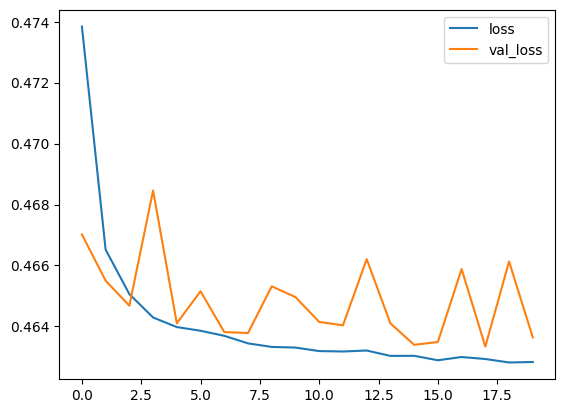

In [25]:
this_history_df[['loss', 'val_loss']].plot()

<Axes: >

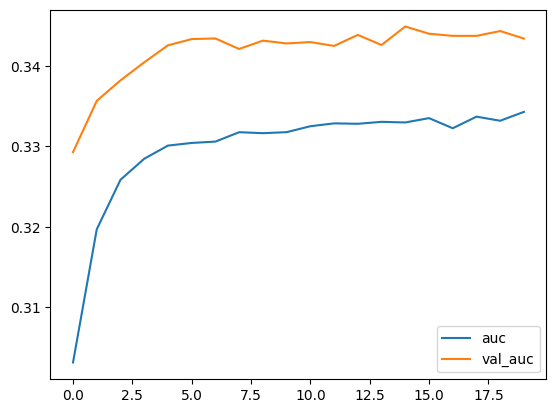

In [26]:
this_history_df[['auc', 'val_auc']].plot()

<Axes: >

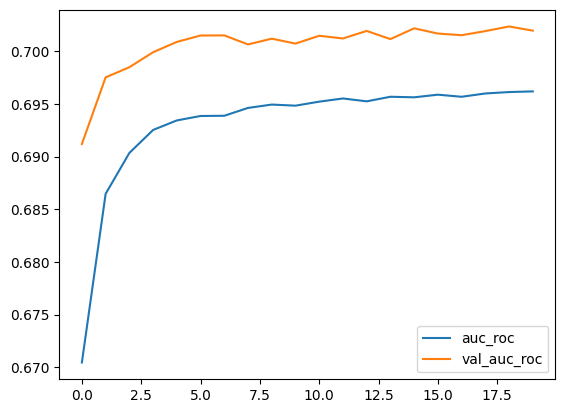

In [27]:
this_history_df[['auc_roc', 'val_auc_roc']].plot()

In [28]:
this_model.save(Path(setup.temp_path).joinpath('11_DATA_model.keras'),save_format='tf')

## Predictions on all data

In [29]:
all_predictions = this_model.predict(X.drop(columns='dset'))

  107/21503 [..............................] - ETA: 30s

2024-02-24 01:51:36.934747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 30s 1ms/step


In [30]:
all_predictions_df = pd.DataFrame(all_predictions, index=X.index) \
    .set_axis(['predict_prob'], axis=1) \
    .reset_index() \
    .merge(business_data[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout']], on='LoanNr_ChkDgt')
    

In [31]:
all_predictions_df[['predict_prob', 'target']].corr(method='spearman')

,predict_prob,target
predict_prob,1.000000,0.281754
target,0.281754,1.000000


##### Threshold Tune & Binary Predictions
Using training probability predictions

In [32]:
all_pred_train = all_predictions_df[all_predictions_df['dset'] == 'train']

In [33]:
thresh_tune_data = sg_plot.get_f1_frame(all_pred_train['target'], 
                                        all_pred_train['predict_prob'])

In [34]:
thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
thresh_tune_data.head(3)

,thresh,f1
10,0.20,0.427696
11,0.22,0.426625
9,0.18,0.425493


In [35]:
best_thresh = thresh_tune_data['thresh'].iloc[0]
best_thresh

0.2

##### Append binary predictions to probability predictions

In [36]:
all_predictions_df['predict_bin'] = sg_plot.get_binary_predictions(all_predictions_df['predict_prob'], best_thresh)

In [37]:
all_predictions_df['predict_bin'].value_counts(normalize=True, dropna=False)

predict_bin
1    0.504166
0    0.495834
Name: proportion, dtype: float64

In [38]:
all_predictions_df.to_parquet(Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'))

## Metrics

In [39]:
all_predictions_df = pd.read_parquet(Path(setup.temp_path).joinpath('11_DATA_predictions.parquet'))

In [40]:
metrics_dset_df = all_predictions_df.groupby('dset') \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_test_df = all_predictions_df[all_predictions_df['dset'] == 'test'] \
    .groupby(['dset', 'dset_naics_holdout']) \
    .apply(lambda x: sg_plot.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
    .reset_index()
metrics_df = pd.concat([metrics_dset_df, metrics_test_df])
metrics_df.to_csv(Path(setup.temp_path).joinpath('11_REPORT_metrics.csv'), index=True)
metrics_df

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout
0,test,0.600069,0.429511,0.300788,0.750832,0.346160,0.706545,NaN
1,train,0.594757,0.427696,0.299839,0.745658,0.341493,0.700845,NaN
2,val,0.596742,0.432627,0.304298,0.748128,0.343544,0.702027,NaN
0,test,0.595481,0.430669,0.301890,0.751047,0.345526,0.702495,0.0
1,test,0.614267,0.425718,0.297193,0.750118,0.348599,0.718693,1.0


## Embeddings
Save the hidden layer weight prior to sigmoid output, for possible later use in unsupervised GNN 

In [41]:
embed_model = Model(inputs=this_model.inputs, outputs=this_model.layers[-2].output) 

In [42]:
embed_out = embed_model.predict(X.drop(columns='dset'))

  164/21503 [..............................] - ETA: 19s

2024-02-24 01:52:28.259256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


21503/21503 [==============================] - 920s 43ms/step


In [43]:
embed_out.shape

(688081, 64)

In [44]:
embed_df = pd.DataFrame(embed_out, index=X.index) 
embed_df.columns = [f'emb_{i:03d}' for i in range(len(embed_df.columns))]
embed_df.reset_index(inplace=True)

In [45]:
embed_df.head()

,LoanNr_ChkDgt,emb_000,emb_001,emb_002,emb_003,emb_004,emb_005,emb_006,emb_007,emb_008,...,emb_054,emb_055,emb_056,emb_057,emb_058,emb_059,emb_060,emb_061,emb_062,emb_063
0,1000014003,0.367337,0.999904,0.999945,0.780299,-0.954236,1.0,0.999989,-0.999997,0.976848,...,0.910234,-1.000000,0.999452,-0.374148,-0.999880,-0.999691,-0.999989,-0.678520,0.999866,1.0
1,1000024006,-0.248733,0.999998,0.998336,0.975962,-0.253451,1.0,0.999745,-0.999987,0.994731,...,0.737153,-0.999999,0.999611,-0.933664,-0.999905,-0.997307,-0.999998,-0.752998,0.998724,1.0
2,1000034009,-0.998280,-0.458599,1.000000,-0.956460,0.627702,1.0,0.999891,-0.997265,0.442348,...,0.984384,-0.999999,0.982626,-0.996749,-0.861439,-1.000000,-0.980049,0.934244,0.999779,1.0
3,1000084002,-0.996765,-0.932968,1.000000,-0.993398,-0.287821,1.0,0.999959,-0.998510,-0.067140,...,0.989444,-1.000000,0.969979,-0.990974,-0.782018,-1.000000,-0.889675,0.934216,0.999901,1.0
4,1000094005,-0.411965,1.000000,0.998479,0.984607,0.212972,1.0,0.999517,-0.999977,0.996745,...,0.571769,-0.999998,0.999206,-0.971120,-0.999944,-0.999163,-0.999997,-0.942753,0.997100,1.0


In [46]:
embed_df.to_parquet(Path(setup.temp_path).joinpath('11_DATA_embeddings.parquet'))